In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import random
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
# from tdqm import tdqm

""" \
Our transformer model will have an input size of (32, 128, 5) \
32 -> batch size \
128 -> sequence length \
5 -> number of features (Open, Low, High, Close) \
"""

In [68]:
# the features are separated into sequences of 128 days, 4 price features and 1 volume feature
seq_len = 128
# target_len = 3

# during a single step the model receives 32 sequences
batch_size = 32

In [69]:
# Stock for the deep learning
ticker = "GOOGL"

In [70]:
# Importing dataset (use the function in data/data.py)
df = pd.read_csv(
    "data/data.csv", usecols=["Date", "High", "Low", "Open", "Close", "Volume"]
)

In [71]:
# Avoid dividing by 0
df["Volume"].replace(to_replace=0, method="ffill", inplace=True)

# Sort the values based on date
df.sort_values("Date", inplace=True)

# Apply moving average with a window of 10 days to all columns
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].rolling(10).mean() 

df.tail()

,Date,High,Low,Open,Close,Volume
6661,2022-11-14,92.391,89.701999,90.684000,91.674001,37950530.0
6662,2022-11-15,93.741,91.001999,91.970000,92.860001,37004050.0
6663,2022-11-16,95.041,92.394999,93.220000,94.087001,34804010.0
6664,2022-11-17,96.079,93.388999,94.189001,95.074001,34001380.0
6665,2022-11-18,96.937,94.267000,95.176000,95.927001,33791360.0


In [72]:
df["Open"] = df["Open"].pct_change()  # Create arithmetic returns column
df["High"] = df["High"].pct_change()  # Create arithmetic returns column
df["Low"] = df["Low"].pct_change()  # Create arithmetic returns column
df["Close"] = df["Close"].pct_change()  # Create arithmetic returns column
df["Volume"] = df["Volume"].pct_change()

# Drop the rows with the NaN created by the percentage change
df.dropna(how="any", axis=0, inplace=True)

In [73]:
# Get the values to create the separation of the dataset
times = sorted(df.index.values)
last_10pct = sorted(df.index.values)[-int(0.1 * len(times))]
last_20pct = sorted(df.index.values)[-int(0.2 * len(times))]

In [74]:
# min-max price columns
min_return = min(
    df[(df.index < last_20pct)][["Open", "High", "Low", "Close"]].min(axis=0)
)
max_return = max(
    df[(df.index < last_20pct)][["Open", "High", "Low", "Close"]].max(axis=0)
)

# Min-max normalize price columns (0-1 range)
df["Open"] = (df["Open"] - min_return) / (max_return - min_return)
df["High"] = (df["High"] - min_return) / (max_return - min_return)
df["Low"] = (df["Low"] - min_return) / (max_return - min_return)
df["Close"] = (df["Close"] - min_return) / (max_return - min_return)

In [75]:
# min-max volume column
min_volume = df[(df.index < last_20pct)]["Volume"].min(axis=0)
max_volume = df[(df.index < last_20pct)]["Volume"].max(axis=0)

# Min-max normalize volume columns (0-1 range)
df["Volume"] = (df["Volume"] - min_volume) / (max_volume - min_volume)

In [76]:
df_train = df[(df.index < last_20pct)]  # Training data are 80% of total data
df_val = df[(df.index >= last_20pct) & (df.index < last_10pct)]
df_test = df[(df.index >= last_10pct)]

# Drop the date column from the splitted datasets
df_train.drop(columns=["Date"], inplace=True)
df_val.drop(columns=["Date"], inplace=True)
df_test.drop(columns=["Date"], inplace=True)

# Train data into arrays np.ndarray
train_data = df_train.values
val_data = df_val.values
test_data = df_test.values
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

df_train.head()

Training data shape: (5325, 5)
Validation data shape: (666, 5)
Test data shape: (665, 5)


/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_17753/2609535530.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop(columns=["Date"], inplace=True)
/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_17753/2609535530.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop(columns=["Date"], inplace=True)
/var/folders/r4/wcp88kdx6r9g4_1wtlb27h2r0000gn/T/ipykernel_17753/2609535530.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.htm

,High,Low,Open,Close,Volume
10,0.533315,0.624841,0.594562,0.555345,0.137539
11,0.403434,0.485776,0.530637,0.358239,0.249561
12,0.374853,0.488245,0.481612,0.363512,0.223069
13,0.362567,0.446667,0.488121,0.328155,0.241760
14,0.281407,0.291742,0.271953,0.329953,0.364811


In [77]:
# df_train.T#[:,0:128]

In [78]:
# encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8)
# src = torch.rand(10, 5, 128)
# out = encoder_layer(src)

In [79]:
# src.size()

# Dataset

In [80]:
class TickerData(Dataset):
    def __init__(self, data: np.ndarray, seq_len: int) -> None:
        """Init function of dataset class

        Args:
            data (np.ndarray): data from the dataframe to numpy
            seq_len (int): len of values to base for the prediction
        """
        self.inputs, self.targets = [], []

        for i in range(seq_len, len(data)):
            # Chunks of  data with a length of 128 df-rows
            self.inputs.append(data[i-seq_len:i])
            
            # Value of 4th column (Close Price) of df-row 128+1
            self.targets.append(data[:, 3][i])
        
        self.inputs, self.targets = torch.FloatTensor(np.array(self.inputs)), torch.FloatTensor(np.array(self.targets))
        # print(self.inputs)
        # print(self.inputs.shape)
        
    def __getitem__(self, idx: int) -> dict:
        """Get item at a certain index

        Args:
            idx (int): index to get the value

        Returns:
            dict: returns the input and the target
        """
        return {'inputs': self.inputs[idx],
                'targets': self.targets[idx]}
    
    def __len__(self) -> int:
        """Length function 

        Returns:
            int: length of the Dataset
        """
        return min(len(self.inputs), len(self.targets))

In [81]:
train_data = TickerData(data=train_data, seq_len=seq_len)
val_data = TickerData(data=val_data, seq_len=seq_len)
test_data = TickerData(data=test_data, seq_len=seq_len)

In [82]:
len(train_data)

5197

# DataLoader

In [83]:
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, drop_last=True)

In [84]:
# for _,batch in enumerate(train_loader):
#     x = batch["inputs"]
#     break

In [85]:
# x

In [86]:
# x.swapaxes(1,2)

# Device

In [87]:
# This concept is also called teacher forceing. 
# The flag decides if the loss will be calculted over all 
# or just the predicted values.
calculate_loss_over_all_values = False

# S is the source sequence length
# T is the target sequence length
# N is the batch size
# E is the feature number

#src = torch.rand((10, 32, 512)) # (S,N,E) 
#tgt = torch.rand((20, 32, 512)) # (T,N,E)
#out = transformer_model(src, tgt)
#
#print(out)

# input_window = 100
# output_window = 5
# batch_size = 10 # batch size
device = torch.device("cpu" if torch.backends.mps.is_available() else "cpu")

In [88]:
device

device(type='cpu')

# Model

In [89]:
# class PositionalEncoding(nn.Module):

#     def __init__(self, d_model, max_len=5000):
#         super(PositionalEncoding, self).__init__()       
#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         #pe.requires_grad = False
#         self.register_buffer('pe', pe)

#     def call(self, x):
#         # Add extra dimension to self.pe
#         self.pe = self.pe.unsqueeze(0)
#         return x + self.pe[:x.size(0), :]


#     def forward(self, x):
#         print(x)
#         # print(x.size())
#         print(self.pe)
#         # print(self.pe.size())
#         # self.pe = self.pe.unsqueeze(0)
#         return x + self.pe[:x.size(0), :]


# class T2V(nn.Module):
    
#     def __init__(self, output_dim=None):
#         super(T2V, self).__init__()
#         self.output_dim = output_dim
        
#         self.W = nn.Parameter(torch.Tensor(input_shape[-1], self.output_dim))
#         nn.init.uniform_(self.W)
        
#         self.P = nn.Parameter(torch.Tensor(input_shape[1], self.output_dim))
#         nn.init.uniform_(self.P)
        
#         self.w = nn.Parameter(torch.Tensor(input_shape[1], 1))
#         nn.init.uniform_(self.w)
        
#         self.p = nn.Parameter(torch.Tensor(input_shape[1], 1))
#         nn.init.uniform_(self.p)

#     def forward(self, x):
#         original = self.w * x + self.p
#         sin_trans = torch.sin(torch.matmul(x, self.W) + self.P)
        
#         return torch.cat([sin_trans, original], dim=-1)

# class Time2Vector(nn.Module):
#   def __init__(self, seq_len):
#     super(Time2Vector, self).__init__()
#     self.seq_len = seq_len

#     # Initialize weights and biases with shape (seq_len)
#     self.weights_linear = nn.Parameter(torch.Tensor(seq_len))
#     self.bias_linear = nn.Parameter(torch.Tensor(seq_len))
#     self.weights_periodic = nn.Parameter(torch.Tensor(seq_len))
#     self.bias_periodic = nn.Parameter(torch.Tensor(seq_len))

#   def forward(self, x):
#     '''Calculate linear and periodic time features'''
#     # print(x[:,:,:4])
#     x = torch.mean(x[:,:,:4], dim=-1) 
#     # print(x)
#     time_linear = self.weights_linear * x + self.bias_linear # Linear time feature
#     time_linear = time_linear.unsqueeze(-1) # Add dimension (batch, seq_len, 1)
    
#     time_periodic = torch.sin(x * self.weights_periodic + self.bias_periodic)
#     time_periodic = time_periodic.unsqueeze(-1) # Add dimension (batch, seq_len, 1)
#     return torch.nan_to_num(torch.cat([time_linear, time_periodic], dim=-1).swapaxes(1,2)) # shape = (batch, seq_len, 2)

class Time2Vector(nn.Module):
    def __init__(self, seq_len):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

        self.weights_linear = nn.Parameter(torch.Tensor(int(self.seq_len)))
        nn.init.uniform_(self.weights_linear)

        self.bias_linear = nn.Parameter(torch.Tensor(int(self.seq_len)))
        nn.init.uniform_(self.bias_linear)

        self.weights_periodic = nn.Parameter(torch.Tensor(int(self.seq_len)))
        nn.init.uniform_(self.weights_periodic)

        self.bias_periodic = nn.Parameter(torch.Tensor(int(self.seq_len)))
        nn.init.uniform_(self.bias_periodic)

    def forward(self, x):
        x = torch.mean(x[:,:,:4], dim=-1)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = time_linear.unsqueeze(-1)

        time_periodic = torch.sin(x * self.weights_periodic + self.bias_periodic)
        time_periodic = time_periodic.unsqueeze(-1)

        return torch.cat([time_linear, time_periodic], dim=-1)

class TransAm(nn.Module):
    def __init__(self,feature_size=128,num_layers=1,dropout=0.0):
        super(TransAm, self).__init__()
        self.model_type = 'Transformer'
        
        self.src_mask = None
        # self.pos_encoder = PositionalEncoding(feature_size)
        self.t2v = Time2Vector(128)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)     
        self.decoder = nn.Linear(128,1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1    
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self,src):
        
        if self.src_mask is None or self.src_mask.size(0) != 7:
            device = src.device
            mask = self._generate_square_subsequent_mask(7).to(device)
            self.src_mask = mask
        # print(src.size())
        # src = self.pos_encoder(src)
        # time2vector = self.t2v(src)
        # print(torch.count_nonzero(torch.isnan(time2vector)), time2vector)
        # print(torch.count_nonzero(torch.isnan(src.swapaxes(1,2))),src.swapaxes(1,2))
        # src = torch.concatenate((self.t2v(src), src.swapaxes(1,2)), axis=1)
        t2v = self.t2v(src)
        # print(t2v.size())
        src = torch.concatenate((t2v, src), axis=2)
        # print(torch.isnan(src).any())
        # print(src.size())
        # print(src.size())
        # output = self.transformer_encoder(src.swapaxes(1,2),self.src_mask)#, self.src_mask)
        output = self.transformer_encoder(src.swapaxes(1,2), self.src_mask)
        # print(output.size())
        output = self.decoder(output[:, -1, :])
        return output

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

In [90]:
# encoder_layer = nn.TransformerEncoderLayer(d_model=128, nhead=8, batch_first=True)
# transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=6)
# src = torch.rand(32, 5, 128)
# out = transformer_encoder(src)

In [91]:
model = TransAm().to(device)

criterion = nn.MSELoss()

lr = 0.005 
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)



In [92]:
# for i, batch in enumerate(train_loader):
#     # data, targets = get_batch(train_data, i,batch_size)
#     data, targets = batch['inputs'], batch['targets']
#     print(targets)
#     print(targets[-1:])

In [93]:
prev_loss = np.Inf

In [94]:
def train_model(train_data, prev_loss):
    model.train() # Turn on the train mode
    total_loss = 0.
    start_time = time.time()

    for i, batch in enumerate(train_loader):
        # data, targets = get_batch(train_data, i,batch_size)
        data, targets = batch['inputs'].to(device), batch['targets'].to(device).unsqueeze(1)
        optimizer.zero_grad()
        # print(data.size())
        output = model(data)  
        # print(output)
        # if calculate_loss_over_all_values:
        #     loss = criterion(output)
        # else:
        loss = criterion(output, targets)
    
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        log_interval = int(len(train_data) / batch_size / 5)
        if i % log_interval == 0 and i > 0:
            cur_loss = total_loss / log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | '
                  'lr {:02.6f} | {:5.2f} ms | '
                  'loss {:5.5f} | ppl {:8.2f}'.format(
                    epoch, i, len(train_data) // batch_size, scheduler.get_lr()[0],
                    elapsed * 1000 / log_interval,
                    cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
            
        if loss < prev_loss:
            
            torch.save(model.state_dict(), 'tranformer_models/state_dict.pt')  # save model state (wights, etc.)
            torch.save(model, 'tranformer_models/model_complete.pt')  # save complete model
            prev_loss = loss

    return prev_loss


In [95]:
# x = torch.tensor([1, 2, np.nan])
# torch.isnan(x).any()

In [96]:
def plot_and_loss(eval_model, data_source,epoch):
    eval_model.eval() 
    total_loss = 0.
    test_result = torch.Tensor(0)    
    truth = torch.Tensor(0)
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            data, target = batch['inputs'].to(device), batch["targets"].to(device).unsqueeze(1)
            # look like the model returns static values for the output window
            output = eval_model(data)    
            if calculate_loss_over_all_values:                                
                total_loss += criterion(output, target).item()
            else:
                total_loss += criterion(output[-1:], target[-1:]).item()
            
            test_result = torch.cat((test_result, output[-1].view(-1).cpu()), 0) #todo: check this. -> looks good to me
            truth = torch.cat((truth, target[-1].view(-1).cpu()), 0)
            
    #test_result = test_result.cpu().numpy()
    len(test_result)

    plt.plot(test_result,color="red")
    plt.plot(truth[:500],color="blue")
    plt.plot(test_result-truth,color="green")
    plt.grid(True, which='both')
    plt.axhline(y=0, color='k')
    plt.savefig('graph/transformer-epoch%d.png'%epoch)
    plt.close()
    
    return total_loss / i

In [97]:
# for _, batch in enumerate(val_loader):
#     # print(batch["targets"])
#     data, targets = batch['inputs'], batch["targets"]
#     print(data.size())

In [98]:
# def predict_future(eval_model, data_source,steps):
#     eval_model.eval() 
#     total_loss = 0.
#     test_result = torch.Tensor(0)    
#     truth = torch.Tensor(0)
#     _ , data = get_batch(data_source, 0,1)
#     with torch.no_grad():
#         for i in range(0, steps,1):
#             input = torch.clone(data[-input_window:])
#             input[-output_window:] = 0     
#             output = eval_model(data[-input_window:])                        
#             data = torch.cat((data, output[-1:]))
            
#     data = data.cpu().view(-1)
    
#     plt.plot(data,color="red")       
#     plt.plot(data[:input_window],color="blue")
#     plt.grid(True, which='both')
#     plt.axhline(y=0, color='k')
#     plt.savefig('graph/transformer-future%d.png'%steps)
#     plt.close()

In [99]:
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
    total_loss = 0.
    eval_batch_size = 1000
    with torch.no_grad():
        for _, batch in enumerate(val_loader):
            # print(batch["targets"])
            data, targets = batch['inputs'].to(device), batch["targets"].to(device).unsqueeze(1)
            
            # print(data.size())
            output = eval_model(data)
            # print(output)
            if calculate_loss_over_all_values:
                total_loss += len(data[0])* criterion(output, targets).cpu().item()
            else:                                
                total_loss += len(data[0])* criterion(output[-1:], targets[-1:]).cpu().item()            
    return total_loss / len(data_source)

In [100]:
# train_data, val_data = get_data()


# criterion = nn.MSELoss()
# lr = 0.005 
# #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
# optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.98)

best_val_loss = float("inf")
epochs = 100 # The number of epochs
best_model = None
prev_loss = np.Inf

for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    prev_loss = train_model(train_data, prev_loss)
    
    
    # if(epoch % 10 == 0):
        #val_loss = plot_and_loss(model, val_data,epoch)

        # predict_future(model, val_data,200)
        
    # else:
    val_loss = evaluate(model, val_data)
        
    print('-' * 89)
    print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.5f} | valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                     val_loss, math.exp(val_loss)))
    print('-' * 89)

    # if val_loss < best_val_loss:
    #    best_val_loss = val_loss
    #    best_model = model

    scheduler.step() 

/opt/miniconda3/envs/TAAC_project/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


| epoch   1 |    32/  162 batches | lr 0.005000 | 18.59 ms | loss 2.19613 | ppl     8.99
| epoch   1 |    64/  162 batches | lr 0.005000 | 11.91 ms | loss 0.02534 | ppl     1.03
| epoch   1 |    96/  162 batches | lr 0.005000 | 12.07 ms | loss 0.03847 | ppl     1.04
| epoch   1 |   128/  162 batches | lr 0.005000 | 12.76 ms | loss 0.01921 | ppl     1.02
| epoch   1 |   160/  162 batches | lr 0.005000 | 12.33 ms | loss 0.00661 | ppl     1.01
-----------------------------------------------------------------------------------------
| end of epoch   1 | time:  2.24s | valid loss 0.04161 | valid ppl     1.04
-----------------------------------------------------------------------------------------
| epoch   2 |    32/  162 batches | lr 0.004802 | 12.67 ms | loss 0.01490 | ppl     1.02
| epoch   2 |    64/  162 batches | lr 0.004802 | 11.80 ms | loss 0.02406 | ppl     1.02
| epoch   2 |    96/  162 batches | lr 0.004802 | 12.65 ms | loss 0.01103 | ppl     1.01
| epoch   2 |   128/  162 batche

In [101]:
model.load_state_dict(torch.load('tranformer_models/state_dict.pt'))

<All keys matched successfully>

In [102]:
model

TransAm(
  (t2v): Time2Vector()
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.0, inplace=False)
    (dropout2): Dropout(p=0.0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.0, inplace

In [103]:
test_losses = []
test_preds = []
num_correct = 0

model.eval()
for (combo_data_3) in test_loader:
    inputs, labels = combo_data_3['inputs'], combo_data_3['targets'].unsqueeze(1)
    inputs, labels = inputs.to(device), labels.to(device)
    # output, h = model(inputs, h)
    output = model(inputs)
    print(output)
    test_preds.append(output.cpu().detach().numpy())
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())
    pred = torch.round(output.squeeze()) #rounds the output to 0/1
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)
        
print("Test loss: {:.3f}".format(np.mean(test_losses)))

tensor([[0.4971],
        [0.4846],
        [0.4814],
        [0.4780],
        [0.4632],
        [0.4597],
        [0.4582],
        [0.4630],
        [0.4663],
        [0.4679],
        [0.4760],
        [0.4728],
        [0.4891],
        [0.5003],
        [0.5085],
        [0.5031],
        [0.4985],
        [0.4871],
        [0.4763],
        [0.4510],
        [0.4519],
        [0.4574],
        [0.4595],
        [0.4621],
        [0.4651],
        [0.4703],
        [0.4720],
        [0.4751],
        [0.4762],
        [0.4781],
        [0.4829],
        [0.4799]], grad_fn=<AddmmBackward0>)
tensor([[0.4765],
        [0.4814],
        [0.4827],
        [0.4826],
        [0.4875],
        [0.4973],
        [0.5079],
        [0.5033],
        [0.5004],
        [0.4991],
        [0.4967],
        [0.4898],
        [0.4919],
        [0.4961],
        [0.4952],
        [0.4852],
        [0.4769],
        [0.4772],
        [0.4703],
        [0.4683],
        [0.4712],
        [0.4736],
 

/opt/miniconda3/envs/TAAC_project/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [104]:
np.concatenate(test_preds, axis=0)

array([[0.4971323 ],
       [0.48460066],
       [0.48137152],
       [0.47802132],
       [0.4631648 ],
       [0.4597229 ],
       [0.4581977 ],
       [0.4630381 ],
       [0.4662603 ],
       [0.46791887],
       [0.4759804 ],
       [0.47281235],
       [0.4891148 ],
       [0.5002863 ],
       [0.5084597 ],
       [0.5030651 ],
       [0.49854293],
       [0.48710716],
       [0.4762887 ],
       [0.45101678],
       [0.45186478],
       [0.45742166],
       [0.45951396],
       [0.46212152],
       [0.4650805 ],
       [0.47031727],
       [0.47195488],
       [0.47507492],
       [0.47624922],
       [0.4781336 ],
       [0.48294306],
       [0.47986436],
       [0.47647268],
       [0.48142305],
       [0.48267022],
       [0.4826189 ],
       [0.48751202],
       [0.4973306 ],
       [0.50787795],
       [0.50331146],
       [0.5004382 ],
       [0.49909985],
       [0.49670053],
       [0.4898007 ],
       [0.4918503 ],
       [0.49608096],
       [0.4952265 ],
       [0.485

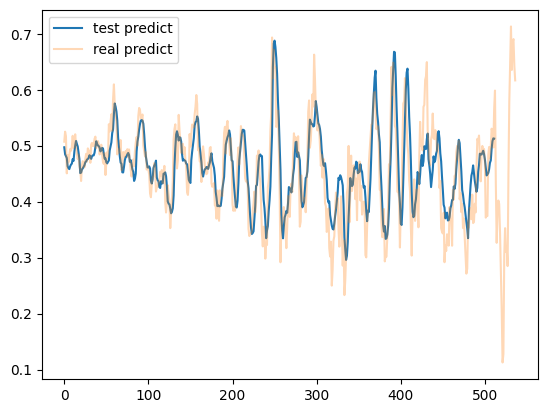

In [105]:
plt.plot(np.concatenate(test_preds, axis=0), label='test predict')
plt.plot(test_loader.dataset[:]['targets'], label= 'real predict', alpha =0.3)
plt.legend()
plt.show()

In [106]:
model.eval()
preds = []
with torch.no_grad():
    for batch in test_loader:
        data, targets = batch["inputs"], batch["targets"]

        preds = model(data)
        print(preds)
#   y_val = model(inputCatColumns, inputNumColumns)
#   preds.append(y_val > 0.) # if y_val are logits
#   loss = loss_function(y_val, test_outputs)
#   print(f'Loss: {loss:.8f}')
# preds = torch.stack(preds)

tensor([[0.4971],
        [0.4846],
        [0.4814],
        [0.4780],
        [0.4632],
        [0.4597],
        [0.4582],
        [0.4630],
        [0.4663],
        [0.4679],
        [0.4760],
        [0.4728],
        [0.4891],
        [0.5003],
        [0.5085],
        [0.5031],
        [0.4985],
        [0.4871],
        [0.4763],
        [0.4510],
        [0.4519],
        [0.4574],
        [0.4595],
        [0.4621],
        [0.4651],
        [0.4703],
        [0.4720],
        [0.4751],
        [0.4762],
        [0.4781],
        [0.4829],
        [0.4799]])
tensor([[0.4765],
        [0.4814],
        [0.4827],
        [0.4826],
        [0.4875],
        [0.4973],
        [0.5079],
        [0.5033],
        [0.5004],
        [0.4991],
        [0.4967],
        [0.4898],
        [0.4919],
        [0.4961],
        [0.4952],
        [0.4852],
        [0.4769],
        [0.4772],
        [0.4703],
        [0.4683],
        [0.4712],
        [0.4736],
        [0.4914],
        [

In [107]:
# class TimeSeriesDataset(object):
#     def __init__(self, data, categorical_cols, target_col, seq_length, prediction_window=1):
#         '''
#         :param data: dataset of type pandas.DataFrame
#         :param categorical_cols: name of the categorical columns, if None pass empty list
#         :param target_col: name of the targeted column
#         :param seq_length: window length to use
#         :param prediction_window: window length to predict
#         '''
#         self.data = data
#         self.categorical_cols = categorical_cols
#         self.numerical_cols = list(set(data.columns) - set(categorical_cols) - set(target_col))
#         self.target_col = target_col
#         self.seq_length = seq_length
#         self.prediction_window = prediction_window
#         self.preprocessor = None

#     def preprocess_data(self):
#         '''Preprocessing function'''
#         X = self.data.drop(self.target_col, axis=1)
#         y = self.data[self.target_col]

#         self.preprocess = ColumnTransformer(
#             [("scaler", StandardScaler(), self.numerical_cols),
#              ("encoder", OneHotEncoder(), self.categorical_cols)],
#             remainder="passthrough"
#         )

#         X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=False)
#         X_train = self.preprocessor.fit_transform(X_train)
#         X_test = self.preprocessor.transform(X_test)

#         if self.target_col:
#             return X_train, X_test, y_train.values, y_test.values
#         return X_train, X_test

#     def frame_series(self, X, y=None):
#         '''
#         Function used to prepare the data for time series prediction
#         :param X: set of features
#         :param y: targeted value to predict
#         :return: TensorDataset
#         '''
#         nb_obs, nb_features = X.shape
#         features, target, y_hist = [], [], []

#         for i in range(1, nb_obs - self.seq_length - self.prediction_window):
#             features.append(torch.FloatTensor(X[i:i + self.seq_length, :]).unsqueeze(0))

#         features_var = torch.cat(features)

#         if y is not None:
#             for i in range(1, nb_obs - self.seq_length - self.prediction_window):
#                 target.append(
#                     torch.tensor(y[i + self.seq_length:i + self.seq_length + self.prediction_window]))
#                 y_hist.append(
#                     torch.tensor(y[i + self.seq_length - 1:i + self.seq_length + self.prediction_window - 1]))
#             target_var, y_hist_var = torch.cat(target), torch.cat(y_hist)
#             return TensorDataset(features_var, target_var, y_hist_var)
#         return TensorDataset(features_var)

#     def get_loaders(self, batch_size: int):
#         '''
#         Preprocess and frame the dataset
#         :param batch_size: batch size
#         :return: DataLoaders associated to training and testing data
#         '''
#         X_train, X_test, y_train, y_test = self.preprocess_data()

#         train_dataset = self.frame_series(X_train, y_train)
#         test_dataset = self.frame_series(X_test, y_test)

#         train_iter = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
#         test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
#         return train_iter, test_iter

In [108]:
device

device(type='cpu')

In [109]:

# model.eval() # Turn on the evaluation mode
# # total_loss = 0.
# # eval_batch_size = 1000
# preds = []
# # with torch.no_grad():
# preds_batch = []
# for _, batch in enumerate(test_loader):
#     # print(batch["targets"])
#     data, targets = batch['inputs'].to(device), batch["targets"].to(device).unsqueeze(1)
#     print(data, targets)
#     # print(data.size())
#     output = model(data)
#     # preds_batch.append(output)
#     print(output)
#     break
#     # loss = criterion(output, targets).cpu().item()
#     # print(f'Loss: {loss:.8f}')
#     # # if calculate_loss_over_all_values:
#     # #     total_loss += len(data[0])* criterion(output, targets).cpu().item()
#     # # else:                                
#     # #     total_loss += len(data[0])* criterion(output[-1:], targets[-1:]).cpu().item() 
               
# # return total_loss / len(data_source)


In [110]:
# (np.concatenate(preds, axis=0)).shape

TypeError: The first input argument needs to be a sequence

In [ ]:
# plt.plot()

In [ ]:
# model.eval()
# preds = []
# with torch.no_grad():
#   y_val = model(inputCatColumns, inputNumColumns)
#   preds.append(y_val > 0.) # if y_val are logits
#   loss = loss_function(y_val, test_outputs)
#   print(f'Loss: {loss:.8f}')
# preds = torch.stack(preds)